# Levenshtein Distance 
compute and rank Levenshtein distance between ST words and competitor sets from BNC lexicon 
- create BNC frequency lexicon 
- read Study tables
- for each ST word compute competitor set (set of most similr words) in the BNC frequency lexicon
- for each ST word rank competitor set in various ways 
- store rankings foreach word in ST dataframe
- visualize distributions and compute correlations 

In [1]:
# import kent library
import sys
sys.path.insert(0, '/data/critt/shared/Spring19/')

import kent
import importlib
importlib.reload(kent)

<module 'kent' from '/data/critt/shared/Spring19/kent.py'>

In [2]:
# Levenshtein distance from https://stackabuse.com/levenshtein-distance-and-text-similarity-in-python/
import numpy as np

def levenshtein(seq1, seq2):  
    size_x = len(seq1) + 1
    size_y = len(seq2) + 1
    matrix = np.zeros ((size_x, size_y))
    for x in range(size_x):
        matrix [x, 0] = x
    for y in range(size_y):
        matrix [0, y] = y

    for x in range(1, size_x):
        for y in range(1, size_y):
            if seq1[x-1] == seq2[y-1]:
                matrix [x,y] = min(
                    matrix[x-1, y] + 1,
                    matrix[x-1, y-1],
                    matrix[x, y-1] + 1
                )
            else:
                matrix [x,y] = min(
                    matrix[x-1,y] + 1,
                    matrix[x-1,y-1] + 1,
                    matrix[x,y-1] + 1
                )
#    print (matrix)
    return (matrix[size_x - 1, size_y - 1])

In [3]:
x = "This is the fisd string"
y = "This is the second string"
levenshtein(x, y) 

5.0

# Task: program a function for spell checker 
 - check wheter word is in BNC freq lexicon (with e.g. freq > 4)
 - otherwise search for set of nearest neighbors
 - return list of most similar words in the BNC

In [4]:
# retrieve similar words from the BNC
from collections import defaultdict
import numpy as np

def dicSim(word, DIC):
    if (word in DIC): return([])

    r = [] # initialize list of most similar words
    m = len(word) # initialize minimum similarity 
    
    for dic in DIC :
        # ignore entries with low frequencies (perhaps typos)
        if(DIC[dic] < 4) : continue

        # computer the levinsthein distance
        lev = int(levenshtein(dic, word))
        
        # initialize list of most similar words
        if(lev < m) :
            r = [dic]
            m = lev
            
        # add word to list of most similar words
        elif(lev == m) : r.append(dic)
        
    return(r)

In [3]:
# read BNC word frequency dictionary 
import re

def readFreqDic(dictionary) :
    Dic = {}
    with open(dictionary,"r", encoding="utf8") as file:
        for entry in file:
            tok, num = re.findall("^(.*?)[\s]+(.*?)$", entry)[0]
            Dic[tok] = int(num)
    return (Dic)


In [4]:
# read BNC frequency dictionary ("Produce a word frequency lexicon from the BNC")
BNC_DIC = readFreqDic('/data/critt/shared/Spring19/lemmaLexicon/BNC.freqLex')

In [5]:
len(BNC_DIC)

604205

In [6]:
import json
english_freq_json = json.dumps(BNC_DIC)
f = open('english_freq.json','w')
f.write(english_freq_json)
f.close()

In [7]:
# Creates a frequency dictionary with key as the lenght of the string and value as a list of key:value containing word:frequency
# It eliminates the numerical, alphanumerical and special characters containing strings
import re
def create_freq_dic(dic):
    new_dic = dict()
    new_dic.setdefault(1,dict())
    for key in dic.keys():
        l = len(key)
        #if l> 20:
            #print(str(key) + "   " + str(dic[key]))
        #new_dic.setdefault(l,dict())
        pattern = r"[a-zA-Z]{"+str(l)+"}"
        is_alpha = re.fullmatch(pattern, key)
        if l == 1: 
            continue
        else:
            if is_alpha:
                try:
                    new_dic[l][key] = dic[key]
                except KeyError as er:
                    new_dic.setdefault(l,dict())
                    new_dic[l][key] = dic[key]
                    #new_dic[l] = {l: dic[key]}
    return new_dic  

In [19]:
# contains a dictionary of dictionary
# key = length, value=dictionary of word and its frequency
new_freq_dic = create_freq_dic(BNC_DIC)

In [8]:
# Create a frequency Dictionary (old approach)
dic_len = {}
for key in BNC_DIC.keys():
    l = len(key)
    try:
        dic_len[l][key] = BNC_DIC[key]
    except KeyError as er:
        dic_len[l] = {l: BNC_DIC[key]}

# Dump a dictionary to the file system - /users/kent/dsahoo/dic_len_words_freq.json
json_dic_of_len_words_freq  = json.dumps(dic_len)
f = open('/users/kent/dsahoo/dic_len_words_freq.json','w')
f.write(json_dic_of_len_words_freq)
f.close()

In [12]:
def dicSim2(token, dic_len_freq):
    similar_list = []
    length = len(token)
    
    matched_list = list(dic_len_freq[length].keys())
    if token in matched_list: 
        return similar_list.append(match)
    else: 
        keys = list(dic_len_freq[length].keys())
        for key in keys:
            lev = int(levenshtein(token, str(key)))
            if lev <= 2:
                similar_list.append(key)
    return similar_list     

In [ ]:
dicSim("sunito", BNC_DIC)

In [ ]:
# retrieve set of most similar words 

dicSim2("sunito", dic_len)

# Task:
# the function "dicSim" comapres (almost) all words in the BNC:
# try to think of ways to make retrieval faster

---------------------

# Generate and quantify competitor sets of study ST words 
- Read ST tables of PARA19 study into dataFrame
- Produce distance measures for competitor sets 
- visualize histogram, regression analysis

In [9]:
# read the PARA19 study data
STdf = kent.readTPDDBtables(["PARA19/Tables/"], "*st", path="/data/critt/tprdb/KENT/")

In [10]:
# All the words in SToken of STdf
source_words = STdf['SToken'].tolist()

In [11]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /users/kent/dsahoo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
def find_levenstine_word_list(word,lev_dist):
    word = word.lower()
    # Stores all the words of same levinstine distance as the target word
    word_list = []
    
    # If target_word is stop word, return empty list
    #if word in stop_words:
       # return word_list
    l = len(word)
    
    # return for target length word = 1
    if l == 1: 
        return word_list
    
    # Find lev_dist for words in length of target word
    d = new_freq_dic[l]
    for w in list(d.keys()):
        if d[w] > 10:
            lev = levenshtein(word,str(w))
            if lev == lev_dist:
                word_list.append(w)
    # Find lev_dist for words in length-1 of target word
    d = new_freq_dic[l-1]
    for w in list(d.keys()):
        # Ignore words with frequency < 10, as they may be typos
        if d[w] > 10:
            lev = levenshtein(word,str(w))
            if lev == lev_dist:
                word_list.append(w)
    
    # Find lev_dist for words in length+1 of target word
    d = new_freq_dic[l+1]
    for w in list(d.keys()):
        if d[w] > 10:
            lev = levenshtein(word,str(w))
            if lev == lev_dist:
                word_list.append(w)
        
    return word_list

In [13]:
# Stores all the SToken with its word-length
source_token_len_map = {}
for t in set(source_words):
    l = len(t)
    try:
        ll = source_token_len_map[l] 
        ll.append(t)
    except KeyError:
        ll = list()
        ll.append(t)
        source_token_len_map[l] = ll

In [20]:
for i in range(10):
    w = source_words[i]
    print(f'{w} --> {find_levenstine_word_list(w, 1)}')

Killer --> ['killed', 'miller', 'tiller', 'filler', 'keller', 'kilter', 'kilmer', 'hiller', 'piller', 'killen', 'koller', 'killers']
nurse --> ['purse', 'curse', 'norse', 'furse', 'nurses', 'nursed', 'nourse']
receives --> ['received', 'receiver', 'deceives', 'receive', 'receivers']
four --> ['your', 'hour', 'tour', 'pour', 'foul', 'sour', 'dour', 'nour', 'cour', 'faur', 'jour', 'for', 'our', 'fur', 'fou', 'flour', 'fours']
life --> ['like', 'line', 'live', 'wife', 'lift', 'lime', 'fife', 'lite', 'rife', 'lice', 'lire', 'lise', 'lifo', 'lie', 'ife', 'liffe', 'lifes', 'lifer']
sentences --> ['sentenced', 'sentencer', 'sentence', 'sentencers']
Hospital --> ['hospitals']
nurse --> ['purse', 'curse', 'norse', 'furse', 'nurses', 'nursed', 'nourse']
Colin --> ['colon', 'colic', 'comin', 'corin', 'coin', 'coli', 'coln', 'colvin', 'collin', 'coulin']
Norris --> ['morris', 'norrie', 'corris']


In [15]:
def find_levenstine_distance(word,lev_dist):
    word_list = []
    l = len(word)
    d = dic_len[l]
    for w in list(d.keys()):
        lev = levenshtein(word,str(w))
        if lev == lev_dist:
            word_list.append(w)
        
    return word_list

In [16]:
# Check if the word is only alphabets
def is_alpha(word): 
    l = len(word)
    pattern = r"[a-zA-Z]{"+str(l)+"}"
    is_alpha = re.fullmatch(pattern, word)
    return is_alpha

In [21]:
# Create a dictionary of source words to a list of lev distance 1 words
from tqdm import tqdm
word_to_lev_dic = {}
for word in tqdm(set(source_words)):
    if is_alpha(word):
        lev_1 = find_levenstine_word_list(word,1)
        word_to_lev_dic[word] = lev_1

100%|██████████| 433/433 [29:12<00:00,  3.62s/it]


In [22]:
#stoken_lev1_wordlist_new.json
#stoken_lev1_w_stopwords_new.json

# convert a dictionary to json
import json
lev1_json = json.dumps(word_to_lev_dic)
# Write a json object to a file.
f = open("/users/kent/dsahoo/stoken_lev1_with_stopwords.json","w")
f.write(lev1_json)
f.close()

In [17]:
# stoken_lev1_wordlist_new contains the dictionary of lev1 competitor set
import json
# reads a file and load a json object
lev1_json = open("/users/kent/dsahoo/stoken_lev1_with_stopwords.json","r").read()
word_to_lev_dic = json.loads(lev1_json)

## Produce various distance measures for competitor sets 

Compute various measures for each ST word $w$ in competitor set $C_w$:
    (i.e. any word $s$ in the BNC with same length as $w$ differing by a one letter(s))
    
1. size $m$ of competitor set (SimS3)
2. sum of competitor set similarity scores: $\sum_{s\in C} 1-(lev /len(s))$ (SimS1)
3. average similarity: $ 1/m \sum_{s\in C} 1-(lev / len(s)) $        (SimS4)
4. sum of log salience (frequency) of competitor words: $\sum_{s\in C} log(salience(s))$ (SimS2)
5. average log salience (frequency) of competitor words: $1/m \sum_{s\in C} log(salience(s))$ (SimS5)

     - for competitor set $C_w$ with two, three, .. , n different letters

6. ranked versions of measures 1 ..5 (divide by $lev$)

    - add competitor metrics for each ST word to dataFrame as feature "SimS1", "SimS2", .... "SimSn"


In [33]:

#frequency_map
# New dictionary with frequency of words
#new_freq_dic

# Contains source word to lev1 distance word list
#word_to_lev_dic

In [21]:
def competitor_sim_scores(token, token_dic, lev,metric='sum'):
    similar_list = list()
    try:
        similar_list = token_dic[token]
    except KeyError as ex:
        pass
    similarity_score = 0
    summation = 0
    avg = 0
    list_length = len(similar_list)
    token_length = len(token)
    if similar_list:
        for word in similar_list:
            score = 1 - (lev / len(word))
            summation += score
        if summation:
            avg = summation/list_length
    
    if metric == 'avg':
        return  avg
    else:
        return summation

import math
def salience_score(token, token_dic, lev, frequency_map,metric='sum'):
    similar_list = list()
    try:
        similar_list = token_dic[token]
    except KeyError as ex:
        pass
    salience_score = 0
    summation = 0
    avg = 0
    list_length = len(similar_list)
    token_length = len(token)
    #word_frequencies = frequency_map[token_length]
    if similar_list:
        for word in similar_list:
            word_frequencies = frequency_map[len(word)]
            freq = word_frequencies[word]
            summation += math.log(freq)
        avg = summation/list_length
        
    if metric == 'avg':
        return  avg
    else:
        return summation

In [22]:
def normalized_sim_scores(token, token_dic, lev):
    similar_list = list()
    try:
        similar_list = token_dic[token]
    except KeyError as ex:
        pass
    similarity_score = 0
    summation = 0
    avg = 0
    list_length = len(similar_list)
    token_length = len(token)
    if similar_list:
        for word in similar_list:
            score = 1 - (lev / len(word))
            summation += score
        
        avg = summation/token_length
    
    return avg

In [23]:
mydf = STdf

In [24]:
def add_competitor_set_count(df, sim_col_name, lev_dic, lev, add_col=False):
    if add_col:
        df[sim_col_name] = 0
        
    for id in list(df.index):
        stoken = df.at[id,'SToken'] 
        try:
            comp_list = lev_dic[stoken]
        except KeyError as ex:
            comp_list = []
        df.at[id, sim_col_name] = len(comp_list)
        
    print(f"The column {sim_col_name} updated successfully")

In [25]:
def add_sim_score(df, sim_col_name, lev_dic, lev,metric='sum', add_col=False):
    if add_col:
        df[sim_col_name] = 0.0
        
    for id in list(df.index):
        stoken = df.at[id,'SToken'] 
        score = competitor_sim_scores(stoken, lev_dic, lev,metric)
        df.at[id, sim_col_name] = float(score)
        
    print(f"The column {sim_col_name} updated successfully")
    


In [26]:
def add_sims7(df, sim_col_name, lev_dic, lev, add_col=False):
    if add_col:
        df[sim_col_name] = 0.0
        
    for id in list(df.index):
        stoken = df.at[id,'SToken'] 
        tgroup = df.at[id,'TGroup']
        score = sims7_score(stoken, tgroup, lev_dic, lev)
        df.at[id, sim_col_name] = float(score)
        
    print(f"The column {sim_col_name} updated successfully")
    
def sims7_score(token, tgroup, token_dic, lev):
    similar_list = list()
    try:
        similar_list = token_dic[token]
    except KeyError as ex:
        pass
    similarity_score = 0
    summation = 0
    avg = 0
    list_length = len(similar_list)
    token_length = len(token)
    ttlen = len(tgroup)
    if similar_list:
        for word in similar_list:
            score = 1 - (lev / max(ttlen,token_length))
            summation += score
        
        avg = summation/token_length
    
    return summation

In [27]:
def add_normalized_sim_score(df, sim_col_name, lev_dic, lev, add_col=False):
    if add_col:
        df[sim_col_name] = 0.0
        
    for id in list(df.index):
        stoken = df.at[id,'SToken'] 
        score = normalized_sim_scores(stoken, lev_dic, lev)
        df.at[id, sim_col_name] = float(score)
        
    print(f"The column {sim_col_name} updated successfully")

In [88]:
competitor_sim_scores('killings', word_to_lev_dic, 1,'avg')

0.8705357142857143

In [29]:
def add_salience_score(df, sim_col_name, lev_dic, frequency_map, lev, metric='sum',add_col=False):
    if add_col:
        df[sim_col_name] = 0.0
        
    for id in list(df.index):
        stoken = df.at[id,'SToken'] 
        score = salience_score(stoken, lev_dic, lev, frequency_map,metric)
        #score = competitor_sim_scores(stoken, lev_dic, lev)
        df.at[id, sim_col_name] = float(score)
        
    print(f"The column {sim_col_name} updated successfully")

In [92]:
add_sims7(newdf,"SimS7", word_to_lev_dic, 1, True)

The column SimS7 updated successfully


In [31]:
# Creates a new data-frame
newdf = STdf.copy()

In [32]:
# word_to_lev_dic -> for each Stoken, has its Ortho neighbors with LD=1
# new_freq_dic -> contains the dic of word: freq separated by word-length

# SimS1 - Sum Similarity
# SimS2 - Avg Similarity
# SimS3 - Sum Salience
# SimS4 - Avg Salience
# SimS5 - Length CompSet

#add_sim_score(newdf, "SimS1", word_to_lev_dic, 1, 'sum', True)
#add_sim_score(newdf, "SimS2", word_to_lev_dic, 1, 'avg', True)
#add_salience_score(newdf,"SimS3",word_to_lev_dic, new_freq_dic,1,"sum",True)
#add_salience_score(newdf,"SimS4",word_to_lev_dic, new_freq_dic,1,"avg",True)
#add_competitor_set_count(newdf, "SimS5", word_to_lev_dic, 1, True)
add_competitor_set_count(newdf, "OrthoSim", word_to_lev_dic, 1, True)
add_normalized_sim_score(newdf, "OrthoSimN", word_to_lev_dic, 1, True)
#add_normalized_sim_score(newdf, "SimS6", word_to_lev_dic, 1, True)


The column OrthoSim updated successfully
The column OrthoSimN updated successfully


In [33]:
newdf['TTlen'] = newdf['TGroup'].apply(len)
newdf['STlen'] = newdf['SToken'].apply(len)

In [34]:
newdf[(newdf.STlen > 2) & (newdf.OrthoSim > 0)][["SToken","OrthoSim","OrthoSimN","Dur","HTra"]].corr()

,OrthoSim,OrthoSimN,Dur,HTra
OrthoSim,1.000000,0.995470,-0.164588,-0.094316
OrthoSimN,0.995470,1.000000,-0.159332,-0.099340
Dur,-0.164588,-0.159332,1.000000,0.060426
HTra,-0.094316,-0.099340,0.060426,1.000000


In [ ]:
# (C) Dur -0.033452	0.230992	-0.041279	0.217769	-0.042846	-0.058252	1.000000	0.096676
# (H) Dur 0.001299	0.109499	-0.003074	0.100976	-0.001479	-0.007075	1.000000	0.047987
# (U) Dur -0.008493	0.087848	-0.010993	0.077121	-0.009849	-0.012167	1.000000	0.076536

## Visualize and correlate competitor sets similarities 
- pre-process STdf data
- Empirical cumulative distribution functions 
- Exclude outliers greater or smaller than 2 SD
-

In [36]:
# exclude outliers in dataframe df 
def excludeOutliers(df, col) :
    mean = np.mean(np.array(df[col]), axis=0)
    sd = np.std(np.array(df[col]), axis=0)
    return(df[(df[col] > mean - 2 * sd) & (df[col] < mean + 2 * sd)])

In [37]:
# Empirical cumulative distribution functions 
def ecdf(data):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

In [66]:
newdf['Pause1'].isna().unique()

array([False])

### Transform Vs Apply

- Transform: The simplest case is trying to assign results of reduction function back to original dataframe (used mostly in conjuction with groupby aggregation, to apply the aggregation back to the dataframe
- Apply: it applies a particular function to all rows of the data frame.

In [68]:
newdf['Pause1Dur'] = newdf.apply(lambda row: row['Pause1'] + row['Dur'], axis=1)

In [69]:
newdf['Pause1Dur1'] = newdf.apply(lambda row: row['Pause1'] + row['Dur1'], axis=1)

### Rename columns

In [ ]:
colmap = {"Pause1Dur1":"pause1dur1", "Pause1Dur":"pause1dur"}
newdf.rename(index=str, columns=colmap)

In [70]:
newdf[["SToken","Pause1Dur","Pause1Dur1"]].head()

,SToken,Pause1Dur,Pause1Dur1
0,Killer,7094,7094
1,nurse,2625,2625
2,receives,2094,2094
3,four,1984,1984
4,life,1344,1344


In [101]:
newdf[(newdf.PoS.str.match(r"^(N|V)"))]["PoS"].unique()

array(['NNP', 'VBP', 'NNS', 'NN', 'VBD', 'VBN', 'VBG', 'VB', 'VBZ'],
      dtype=object)

In [108]:
newdf['PoS'].unique()

array(['NNP', 'VBP', 'NNS', 'CD', 'NN', 'VBD', 'VBN', 'IN', 'DT', 'VBG',
       'PRP$', '.', 'JJ', 'PRP', ',', 'MD', 'VB', 'TO', 'JJS', 'RB', 'CC',
       'RP', 'VBZ', 'JJR', 'WP', 'POS', 'WDT', 'RBR', 'RBS', 'WRB', ':'],
      dtype=object)

In [109]:
# Pre process data for dependent and independent variables
# - take out outliers (-2< and >2 SD)
# - take out values < 0

# independent variable
indFeat = "OrthoSim"

# dependent Variable
depFeat = "Dur"


###########
# pre-process data
#data = mydf[(mydf.SimS1 > 0)]
#data = mydf
data = newdf
# exclude values <= 0 of independent variable
data = data[(data[indFeat] > 0)]

# exclude outliers of independent variable
data = excludeOutliers(data, indFeat)

# compute log transformation for independent Variable
indFeatL = indFeat + "Log"
data[indFeatL] = np.log(data[indFeat])

#######
# exclude outliers for dependent variable
data = data[(data[depFeat] > 0)]
data = excludeOutliers(data, depFeat)

# compute log transformation for dependent Variable
depFeatL = depFeat + "Log"
data[depFeatL] = np.log(data[depFeat])

#######
# take log-transformation of dependent / indpendent variable
depFeat = depFeatL
indFeat = indFeatL

#######
# compute "STlen" length of SToken
data["STlen"] = data["SToken"].apply(len)

# show data only for ST words of langth 4
#data = data[(data.STlen == 4) & (data.SimS1 > 0)]

data = data[(newdf.PoS.str.match(r"^(N|P)"))]

#######
# show correlation matrix
data = data[(data.STlen > 2)]
#data = data[(data.SimS1 > 0)]

#print(data[["SToken","SimS1"]])
#print(data[["SimS1", "SimS2", "SimS3","SemanticSim","Dur","HTra" ]].corr())
print(data[["OrthoSim","TrtS","TrtT","FFDur","Pause1Dur","Pause1Dur1","Dur" ]].corr())
from scipy import stats

stat = stats.linregress(data[depFeat], data[indFeat])
print(f"p-value for correlation between {depFeat} and {indFeat} is {stat.pvalue:.10f}")

            OrthoSim      TrtS      TrtT     FFDur  Pause1Dur  Pause1Dur1  \
OrthoSim    1.000000 -0.169951 -0.091245 -0.052960  -0.045173   -0.029891   
TrtS       -0.169951  1.000000  0.212289  0.265708   0.150228    0.141787   
TrtT       -0.091245  0.212289  1.000000 -0.016647   0.316917    0.247426   
FFDur      -0.052960  0.265708 -0.016647  1.000000   0.057648    0.074811   
Pause1Dur  -0.045173  0.150228  0.316917  0.057648   1.000000    0.957063   
Pause1Dur1 -0.029891  0.141787  0.247426  0.074811   0.957063    1.000000   
Dur        -0.253309  0.198850  0.400074 -0.006584   0.421192    0.278953   

                 Dur  
OrthoSim   -0.253309  
TrtS        0.198850  
TrtT        0.400074  
FFDur      -0.006584  
Pause1Dur   0.421192  
Pause1Dur1  0.278953  
Dur         1.000000  
p-value for correlation between DurLog and OrthoSimLog is 0.0000000000


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


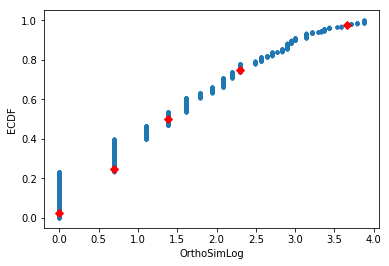

/usr/local/lib64/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


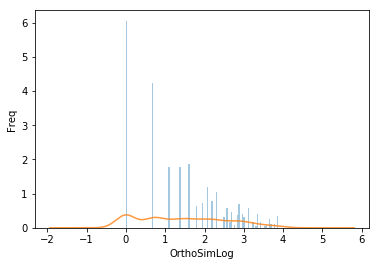

In [110]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

######################
# visualization of independent variable
dataInd = data[indFeat]

## Empirical cumulative distribution functions 
# Compute percentiles: ptiles_vers
percentiles = np.array([2.5, 25, 50, 75, 97.5])
ptiles_vers = np.percentile(dataInd, percentiles)

x, y = ecdf(dataInd)

# Generate plot
_ = plt.plot(x, y, marker = '.', linestyle='none')
_ = plt.xlabel(indFeat)
_ = plt.ylabel("ECDF")
_ = plt.plot(ptiles_vers, percentiles/100, marker='D', color='red', linestyle="none")

plt.show()

##### Histogram and density function 

s1 = pd.Series(dataInd)
s1.plot.hist(bins=100,normed=True, alpha=0.4)
s1.plot.density(alpha=0.8)

#s1.plot.density(alpha=0.8)
plt.xlabel(indFeat)
plt.ylabel('Freq')
plt.show()


/usr/local/lib64/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


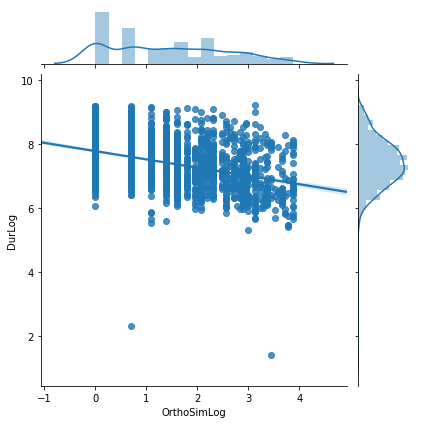

In [111]:
import seaborn as sns

# Regression graph

sns.jointplot(y=depFeat, x=indFeat, data=data, kind="reg");
plt.show()

In [112]:
from scipy import stats
#stats.ttest_ind(STdf["SimS1"], STdf["Ins"])
stats.linregress(newdf["OrthoSim"], newdf["Dur"])

LinregressResult(slope=-19.614496082256952, intercept=1769.5740580156114, rvalue=-0.14231387236190665, pvalue=6.486878518003422e-51, stderr=1.300208202901959)

                            OLS Regression Results                            
Dep. Variable:                 DurLog   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     337.1
Date:                Wed, 14 Aug 2019   Prob (F-statistic):           3.19e-69
Time:                        14:09:54   Log-Likelihood:                -1878.7
No. Observations:                1825   AIC:                             3761.
Df Residuals:                    1823   BIC:                             3772.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       7.7712      0.026    303.062      

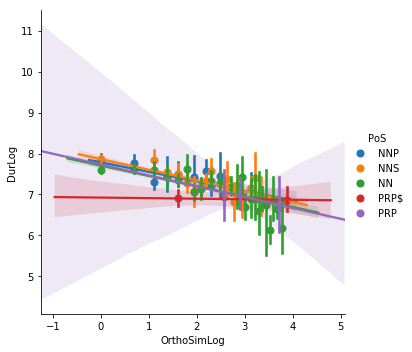

In [115]:
import statsmodels.formula.api as smf
import statsmodels.api as sma
hue = "PoS"
form =depFeat + "~" + indFeat 
#form =depFeat + "~" + indFeat + "* "+hue 
lmf = smf.ols(formula=form, data=data).fit()

print(lmf.summary())

sns.lmplot(y=depFeat, x=indFeat, hue=hue, x_estimator=np.mean, data=data);

plt.show()


## Semantic Neighbourhood using Word2Vec

In [40]:
from gensim.models import KeyedVectors
# load the Stanford GloVe model
filename = '/data/critt/shared/Spring19/w2v/glove/glove.6B.100d.word2vec.txt'
modelSF100 = KeyedVectors.load_word2vec_format(filename, binary=False)

In [41]:
# Returns a list of semantic competitor words based on the score_limit
def semantic_competitor(comp_tuple_list, score_limit = 0.7):
    comp_list = []
    for word,score in comp_tuple_list:
        if word in stop_words:
            return comp_list
        if not word.isalpha():
            return comp_list
        if score > score_limit:
            if word.isalpha() and word not in stop_words:
                comp_list.append(word)
    return comp_list


# Creates a dictionary of word to comp_list for each word in the source_words list
def find_semantic_word_dic(source_words):
    token_to_semantic_words_dic = dict()
    for word in set(source_words):
        try:
            # Returns a list of tuple(word, score)
            result = modelSF100.most_similar(word.lower(), negative=None, topn=100)
            # sim_score = 0.7
            comp_list = semantic_competitor(result)
        except KeyError as ex:
            comp_list = []

        token_to_semantic_words_dic[word] = comp_list
    return token_to_semantic_words_dic

token_to_semantic_words_dic = find_semantic_word_dic(source_words)

In [213]:
for i in range(50):
    w = source_words[i]
    l = find_semantic_word_dic([w])
    if l[w] :
        print(l)

{'Killer': ['killers', 'murderer']}
{'nurse': ['doctor', 'nurses']}
{'receives': ['receive']}
{'four': ['three', 'five', 'six', 'eight', 'two', 'seven', 'nine', 'ten', 'one']}
{'life': ['lives', 'man', 'well', 'mind', 'years']}
{'sentences': ['sentence', 'imprisonment', 'sentenced', 'punishment']}
{'Hospital': ['clinic', 'medical', 'hospitals', 'nursing']}
{'nurse': ['doctor', 'nurses']}
{'Colin': ['powell', 'condoleezza', 'donald']}
{'imprisoned': ['jailed', 'freed', 'detained', 'incarcerated', 'tortured', 'sentenced', 'exiled', 'murdered', 'arrested', 'convicted']}
{'life': ['lives', 'man', 'well', 'mind', 'years']}
{'killing': ['killed', 'wounding', 'kill', 'attack', 'murdering', 'suicide', 'dead', 'murder', 'kills', 'civilians']}
{'four': ['three', 'five', 'six', 'eight', 'two', 'seven', 'nine', 'ten', 'one']}
{'patients': ['doctors', 'patient', 'treatment', 'treat', 'treating', 'physicians', 'cancer', 'treatments', 'care', 'sufferers', 'medications', 'hospitals', 'treated', 'medic

In [149]:
token_to_semantic_words_dic

{'on': [],
 'Beijing': ['china',
  'seoul',
  'chinese',
  'taipei',
  'shanghai',
  'taiwan',
  'hong'],
 'ahead': ['coming',
  'next',
  'start',
  'behind',
  'week',
  'move',
  'sunday',
  'weekend',
  'second',
  'saturday',
  'heading',
  'third',
  'despite',
  'last',
  'put',
  'friday',
  'fourth',
  'expected',
  'came',
  'tuesday',
  'back'],
 'climbed': ['jumped',
  'slipped',
  'tumbled',
  'fell',
  'surged',
  'slid',
  'rose',
  'soared',
  'dipped',
  'slumped',
  'dropped',
  'leapt',
  'plunged',
  'plummeted',
  'falling',
  'risen',
  'leaped',
  'retreated',
  'inched'],
 'fighting': ['fight',
  'battles',
  'battling',
  'conflict',
  'forces',
  'rebels',
  'fought',
  'struggle',
  'violence',
  'insurgency',
  'battle',
  'fighters',
  'war',
  'troops',
  'insurgents',
  'clashes'],
 'economic': ['economy',
  'financial',
  'growth',
  'economies',
  'global',
  'crisis',
  'policy',
  'development',
  'stability',
  'trade',
  'monetary',
  'reforms'],
 '

In [43]:
# Adds a new column for semantic similarity in the data-frame and update its values
def add_semantic_sim_score(df, sim_col_name, token_to_semantic_words_dic, add_col=False):
    if add_col:
        df[sim_col_name] = 0
        
    for id in list(df.index):
        stoken = mydf.at[id,'SToken'] 
        try:
            comp_set = token_to_semantic_words_dic[stoken]
        except KeyError as ex:
            comp_set = []
        mydf.at[id, sim_col_name] = int(len(comp_set))
        
    print(f"The column {sim_col_name} updated successfully")

In [44]:
add_semantic_sim_score(mydf, 'SemanticSim', token_to_semantic_words_dic,True)

The column SemanticSim updated successfully


In [45]:
mydf.head()

,Id,STseg,Study,Session,SL,TL,Task,Text,Part,SToken,...,AltT,CountT,ProbT,HTra,HSeg,HCross,SimS1,SimS3,SimS2,SemanticSim
0,1,1,PARA19,P01_C1,en,en,C,1,P01,Killer,...,5,6,0.4615,1.8920,1.2389,1.8920,0.835317,12,4.578891,2
1,2,1,PARA19,P01_C1,en,en,C,1,P01,nurse,...,2,10,0.7692,0.7793,0.7793,1.8230,0.814286,7,5.358831,2
2,3,1,PARA19,P01_C1,en,en,C,1,P01,receives,...,6,6,0.4615,2.1416,1.1401,1.8230,0.874206,5,6.960643,1
3,4,1,PARA19,P01_C1,en,en,C,1,P01,four,...,3,7,0.5385,1.4573,0.7793,1.4885,0.736275,17,6.994141,9
4,5,1,PARA19,P01_C1,en,en,C,1,P01,life,...,2,9,0.6923,0.8905,0.8905,0.8905,0.749074,18,6.328766,5


In [154]:
# Pre process data for dependent and independent variables
# - take out outliers (-2< and >2 SD)
# - take out values < 0

# independent variable
indFeat = "SemanticSim"

# dependent Variable
depFeat = "Dur"


###########
# pre-process data
data = mydf

# exclude values <= 0 of independent variable
data = data[(data[indFeat] > 0)]

# exclude outliers of independent variable
data = excludeOutliers(data, indFeat)

# compute log transformation for independent Variable
indFeatL = indFeat + "Log"
data[indFeatL] = np.log(data[indFeat])

#######
# exclude outliers for dependent variable
data = data[(data[depFeat] > 0)]
data = excludeOutliers(data, depFeat)

# compute log transformation for dependent Variable
depFeatL = depFeat + "Log"
data[depFeatL] = np.log(data[depFeat])

#######
# take log-transformation of dependent / indpendent variable
depFeat = depFeatL
indFeat = indFeatL

#######
# compute "STlen" length of SToken
data["STlen"] = data["SToken"].apply(len)

# show data only for ST words of langth 4
#data = data[(data.STlen == 4) & (data.SimS1 > 0)]

#######
# show correlation matrix
#data = data[(data.STlen == 4)]
#data = data[(data.SimS1 > 0)]

#print(data[["SToken","SimS1"]])
print(data[[ "SemanticSim","Dur" ]].corr())

             SemanticSim      Dur
SemanticSim      1.00000  0.09201
Dur              0.09201  1.00000


#### Calculate the p-value of the correlation

In [155]:
from scipy import stats
#stats.ttest_ind(STdf["SimS1"], STdf["Ins"])
stats.linregress(STdf["SemanticSim"], STdf["Dur"])

LinregressResult(slope=60.94747760205721, intercept=1148.2220719245397, rvalue=0.09344072918335353, pvalue=8.749636040030878e-23, stderr=6.189296765395732)

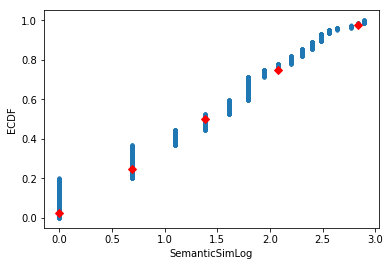

/usr/local/lib64/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


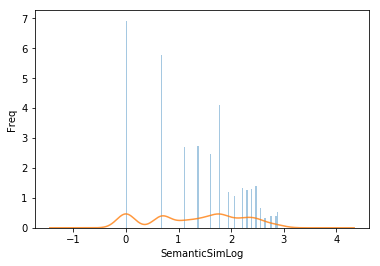

In [631]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

######################
# visualization of independent variable
dataInd = data[indFeat]

## Empirical cumulative distribution functions 
# Compute percentiles: ptiles_vers
percentiles = np.array([2.5, 25, 50, 75, 97.5])
ptiles_vers = np.percentile(dataInd, percentiles)

x, y = ecdf(dataInd)

# Generate plot
_ = plt.plot(x, y, marker = '.', linestyle='none')
_ = plt.xlabel(indFeat)
_ = plt.ylabel("ECDF")
_ = plt.plot(ptiles_vers, percentiles/100, marker='D', color='red', linestyle="none")

plt.show()

##### Histogram and density function 

s1 = pd.Series(dataInd)
s1.plot.hist(bins=100,normed=True, alpha=0.4)
s1.plot.density(alpha=0.8)

#s1.plot.density(alpha=0.8)
plt.xlabel(indFeat)
plt.ylabel('Freq')
plt.show()

/usr/local/lib64/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


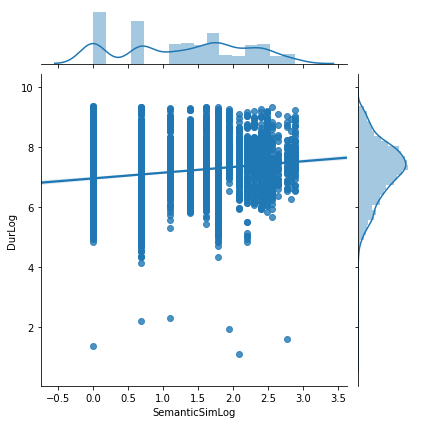

In [632]:
import seaborn as sns

# Regression graph

sns.jointplot(y=depFeat, x=indFeat, data=data, kind="reg");
plt.show()

                            OLS Regression Results                            
Dep. Variable:                 DurLog   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     389.8
Date:                Wed, 10 Jul 2019   Prob (F-statistic):               0.00
Time:                        15:18:09   Log-Likelihood:                -4103.1
No. Observations:                3574   AIC:                             8220.
Df Residuals:                    3567   BIC:                             8263.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

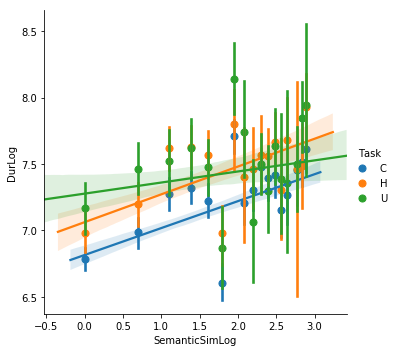

In [224]:
import statsmodels.formula.api as smf
import statsmodels.api as sma

form =depFeat + "~" + indFeat 
form =depFeat + "~" + "STlen +" +  indFeat + "* Task" 
lmf = smf.ols(formula=form, data=data).fit()

print(lmf.summary())

sns.lmplot(y=depFeat, x=indFeat, hue="Task", x_estimator=np.mean, data=data);

plt.show()


## Produce a word frequency lexicon from the BNC
auxilliary functions no need to repeat this ...
